## Error analysis 

Here we test how well do the ZA and TWA tensors do at reproducing the fluxes? 

In particular we look at two metrics: 
- Errors

- Correlations

In [2]:
# load modules 

import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
%matplotlib inline
from xgcm import Grid

In [3]:
# load ZA data 

UpCp = xr.open_dataset('analysis_data_files/UpCp_ZA_50km.nc')
VpCp = xr.open_dataset('analysis_data_files/VpCp_ZA_50km.nc')
WpCp = xr.open_dataset('analysis_data_files/WpCp_ZA_50km.nc')

dCdx = xr.open_dataset('analysis_data_files/dCdx_ZA_50km.nc')
dCdy = xr.open_dataset('analysis_data_files/dCdy_ZA_50km.nc')
dCdz = xr.open_dataset('analysis_data_files/dCdz_ZA_50km.nc')

In [4]:
flux_ZA = xr.Dataset({'UpCp':UpCp.UpCp, 'VpCp':VpCp.VpCp, 'WpCp':WpCp.WpCp})
grads_ZA = xr.Dataset({'dCdx':dCdx.dCdx, 'dCdy':dCdy.dCdy, 'dCdz':dCdz.dCdz})

In [5]:
diff_tensor_ZA = xr.open_dataset('analysis_data_files/diff_tensor_ZA_50km.nc')

In [6]:
# load TWA data

UppCpp = xr.open_dataset('analysis_data_files/UppCpp_TWA_50km_av800.nc')
VppCpp = xr.open_dataset('analysis_data_files/VppCpp_TWA_50km_av800.nc')

dChatdx = xr.open_dataset('analysis_data_files/dCdx_TWA_50km_av800.nc')
dChatdy = xr.open_dataset('analysis_data_files/dCdy_TWA_50km_av800.nc')

In [7]:
zeta_bar = xr.open_dataset('analysis_data_files/zeta_bar_800.nc')
zeta_bar_coarse = zeta_bar.zeta.coarsen(XC=10, YC=10).mean()

In [8]:
flux_TWA = xr.Dataset({'UppCpp':UppCpp.UppCpp, 'VppCpp':VppCpp.VppCpp})
grads_TWA = xr.Dataset({'dCdx':dChatdx.dCdx, 'dCdy':dChatdy.dCdy})

In [9]:
diff_tensor_TWA = xr.open_dataset('analysis_data_files/diff_tensor_TWA_50km_av800.nc')

In [10]:
# reconstruct fluxes and estimate errors for ZA
def flux_reconstruct_ZA(tensor, flux, grads):

    recUflux = -(tensor.sel(i=0, j=0)*grads.dCdx + tensor.sel(i=0, j=1)*grads.dCdy + tensor.sel(i=0, j=2)*grads.dCdz)
    recVflux = -(tensor.sel(i=1, j=0)*grads.dCdx + tensor.sel(i=1, j=1)*grads.dCdy + tensor.sel(i=1, j=2)*grads.dCdz)
    recWflux = -(tensor.sel(i=2, j=0)*grads.dCdx + tensor.sel(i=2, j=1)*grads.dCdy + tensor.sel(i=2, j=2)*grads.dCdz)
    
    errU = np.abs(flux.UpCp - recUflux)/np.abs(flux.UpCp)
    errV = np.abs(flux.VpCp - recVflux)/np.abs(flux.VpCp)
    errW = np.abs(flux.WpCp - recWflux)/np.abs(flux.WpCp)
    
    flux_rec=xr.Dataset({'UpCp':recUflux, 'VpCp':recVflux, 'WpCp':recWflux,
                                'errU':errU, 'errV':errV, 'errW':errW})
    
    return flux_rec

In [11]:
rec_flux_ZA = flux_reconstruct_ZA(diff_tensor_ZA.Kfast,
                                     flux_ZA.sel(tracer_num=1), 
                                     grads_ZA.sel(tracer_num=1))

rec_flux_ZA['tracer_num'] = 1

for i in range(2,21):
    
    if np.mod(i,2)==0:
        diff_tensor_temp = diff_tensor_ZA.Kslow
    else:
        diff_tensor_temp = diff_tensor_ZA.Kfast
    
    
    temp = flux_reconstruct_ZA(diff_tensor_ZA.Kfast,
                                     flux_ZA.sel(tracer_num=i), 
                                     grads_ZA.sel(tracer_num=i))
    temp['tracer_num'] = i
    
    rec_flux_ZA = xr.concat([rec_flux_ZA, temp], dim='tracer_num')
    


In [12]:
# reconstruct fluxes and estimate errors for TWA
def flux_reconstruct_TWA(tensor, flux, grads):

    recUflux = -(tensor.sel(i=0, j=0)*grads.dCdx + tensor.sel(i=0, j=1)*grads.dCdy)
    recVflux = -(tensor.sel(i=1, j=0)*grads.dCdx + tensor.sel(i=1, j=1)*grads.dCdy)

    errU = np.abs(flux.UppCpp - recUflux)/np.abs(flux.UppCpp)
    errV = np.abs(flux.VppCpp - recVflux)/np.abs(flux.VppCpp)
    
    flux_rec=xr.Dataset({'UpCp':recUflux, 'VpCp':recVflux,
                                'errU':errU, 'errV':errV})
    
    return flux_rec

In [13]:
rec_flux_TWA = flux_reconstruct_TWA(diff_tensor_TWA.Kfast,
                                     flux_TWA.sel(tracer_num=1), 
                                     grads_TWA.sel(tracer_num=1))

rec_flux_TWA['tracer_num'] = 1

for i in range(2,21):
    
    if np.mod(i,2)==0:
        diff_tensor_temp = diff_tensor_TWA.Kslow
    else:
        diff_tensor_temp = diff_tensor_TWA.Kfast
    
    
    temp = flux_reconstruct_TWA(diff_tensor_temp,
                                     flux_TWA.sel(tracer_num=i), 
                                     grads_TWA.sel(tracer_num=i))
    temp['tracer_num'] = i
    
    rec_flux_TWA = xr.concat([rec_flux_TWA, temp], dim='tracer_num')

In [35]:
import matplotlib
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

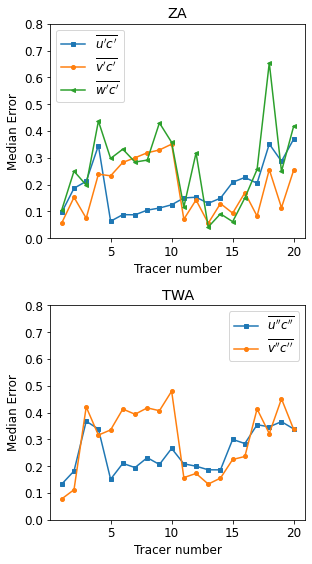

In [50]:
plt.figure(figsize=(4.5,8))
plt.subplot(211)
rec_flux_ZA.errU.sel(YC=slice(250e3, 1750e3)).median(['XC', 'YC', 'Z']).plot(marker='s', markersize=4, label='$\overline{u^\prime c^\prime}$')
rec_flux_ZA.errV.sel(YC=slice(250e3, 1750e3)).median(['XC', 'YC', 'Z']).plot(marker='o', markersize=4, label='$\overline{v^\prime c^\prime}$')
rec_flux_ZA.errW.sel(YC=slice(250e3, 1750e3)).median(['XC', 'YC', 'Z']).plot(marker='<', markersize=4, label='$\overline{w^\prime c^\prime}$')
plt.ylim([0, 0.8])
plt.title('ZA')
plt.legend()
plt.ylabel('Median Error')
plt.xlabel('Tracer number')

plt.subplot(212)
rec_flux_TWA.errU.sel(YC=slice(250e3, 1750e3)).median(['XC', 'YC', 'T']).plot(marker='s', markersize=4,
                                                                              label='$\overline{u^{\prime \prime} c^{\prime \prime}}$')
rec_flux_TWA.errV.sel(YC=slice(250e3, 1750e3)).median(['XC', 'YC', 'T']).plot(marker='o', markersize=4, 
                                                                              label='$\overline{v^{\prime \prime} c^{\prime \prime}}$')
plt.ylim([0, 0.8])
plt.title('TWA')
plt.legend()
plt.ylabel('Median Error')
plt.xlabel('Tracer number')

plt.tight_layout()

plt.savefig('figures/median_error_vs_tracernum.pdf')

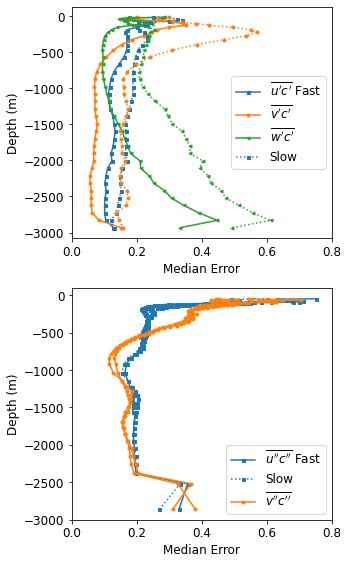

In [49]:
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(5,8))
plt.subplot(211)

rec_flux_ZA.errU.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=slice(1,19,2)
                                                 ).median(['XC', 'YC','tracer_num']).plot( y='Z', marker='s', markersize=3, color=cmap(0), label='$\overline{u^\prime c^\prime}$ Fast')
rec_flux_ZA.errV.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=slice(1,19,2)
                                                 ).median(['XC', 'YC','tracer_num']).plot( y='Z', marker='o', markersize=3,color=cmap(1),label='$\overline{v^\prime c^\prime}$')
rec_flux_ZA.errW.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=slice(1,19,2)
                                                 ).median(['XC', 'YC','tracer_num']).plot( y='Z', marker='<',markersize=3, color=cmap(2),label='$\overline{w^\prime c^\prime}$')

rec_flux_ZA.errU.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=slice(2,21,2)
                                                 ).median(['XC', 'YC','tracer_num']).plot( y='Z', marker='s', markersize=3, color=cmap(0), linestyle=':', label='Slow')
rec_flux_ZA.errV.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=slice(2,21,2)
                                                 ).median(['XC', 'YC','tracer_num']).plot( y='Z', marker='o', markersize=3, color=cmap(1), linestyle=':')
rec_flux_ZA.errW.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=slice(2,21,2)
                                                 ).median(['XC', 'YC','tracer_num']).plot( y='Z', marker='<', markersize=3, color=cmap(2), linestyle=':')

plt.xlim([0,0.8])
plt.ylabel('Depth (m)')
plt.xlabel('Median Error')
plt.legend()

plt.subplot(212)
plt.plot(rec_flux_TWA.errU.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=slice(1,19,2)).median(['tracer_num','XC', 'YC']),
         zeta_bar_coarse.sel(YC=slice(250e3, 1750e3)).median(['XC', 'YC']), 
         marker='s',markersize=3, color=cmap(0),  label='$\overline{u^{\prime \prime} c^{\prime \prime}}$ Fast')
plt.plot(rec_flux_TWA.errU.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=slice(2,20,2)).median(['tracer_num','XC', 'YC']),
         zeta_bar_coarse.sel(YC=slice(250e3, 1750e3)).median(['XC', 'YC']), 
         marker='s', markersize=3, color=cmap(0), linestyle=':', label='Slow')

plt.plot(rec_flux_TWA.errV.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=slice(1,19,2)).median(['tracer_num','XC', 'YC']),
         zeta_bar_coarse.sel(YC=slice(250e3, 1750e3)).median(['XC', 'YC']), 
         marker='o',markersize=3, color=cmap(1),  label='$\overline{v^{\prime \prime} c^{\prime \prime}}$')
plt.plot(rec_flux_TWA.errV.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=slice(2,20,2)).median(['tracer_num','XC', 'YC']),
         zeta_bar_coarse.sel(YC=slice(250e3, 1750e3)).median(['XC', 'YC']), 
         marker='o',markersize=3, color=cmap(1))
plt.xlim([0,0.8])
plt.ylabel('Depth (m)')
plt.xlabel('Median Error')
plt.legend()
plt.tight_layout()
plt.savefig('figures/median_error_vs_dept.pdf')

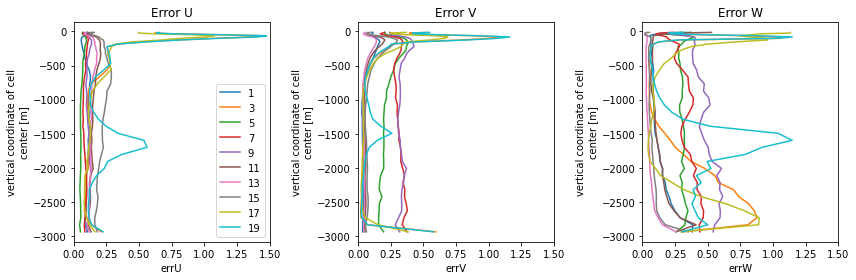

In [132]:
plt.figure(figsize=(12,4))
plt.subplot(131)
for i in range(1,20,2):
    rec_flux_ZA.errU.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=i).median(['XC', 'YC']).plot( y='Z', label=i)
plt.xlim(0,1.5)
plt.legend()
plt.title('Error U')
plt.subplot(132)
for i in range(1,20,2):
    rec_flux_ZA.errV.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=i).median(['XC', 'YC']).plot( y='Z')
plt.xlim(0,1.5)
plt.title('Error V')
plt.subplot(133)
for i in range(1,20,2):
    rec_flux_ZA.errW.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=i).median(['XC', 'YC']).plot( y='Z')
plt.xlim(0,1.5)
plt.title('Error W')
plt.tight_layout()

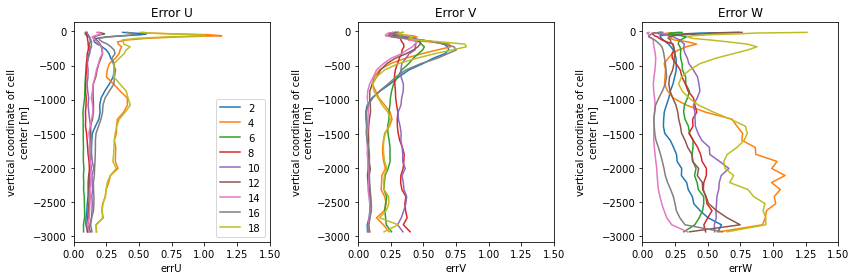

In [131]:
plt.figure(figsize=(12,4))
plt.subplot(131)
for i in range(2,20,2):
    rec_flux_ZA.errU.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=i).median(['XC', 'YC']).plot( y='Z', label=i)
plt.xlim(0,1.5)
plt.legend()
plt.title('Error U')
plt.subplot(132)
for i in range(2,20,2):
    rec_flux_ZA.errV.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=i).median(['XC', 'YC']).plot( y='Z')
plt.xlim(0,1.5)
plt.title('Error V')
plt.subplot(133)
for i in range(2,20,2):
    rec_flux_ZA.errW.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=i).median(['XC', 'YC']).plot( y='Z')
plt.xlim(0,1.5)
plt.title('Error W')
plt.tight_layout()

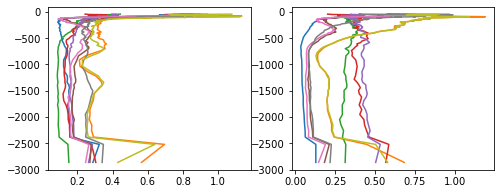

In [224]:
plt.figure(figsize=(8,3))

plt.subplot(121)
for i in range(1,19,2):
    plt.plot(rec_flux_TWA.errU.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=i).median(['XC', 'YC']),
         zeta_bar_coarse.zeta.sel(YC=slice(250e3, 1750e3)).median(['XC', 'YC']), 
         )
    
plt.subplot(122)
for i in range(1,19,2):
    plt.plot(rec_flux_TWA.errV.sel(YC=slice(250e3, 1750e3)).sel(tracer_num=i).median(['XC', 'YC']),
         zeta_bar_coarse.zeta.sel(YC=slice(250e3, 1750e3)).median(['XC', 'YC']), 
         )    

In [ ]:
# correlations

In [236]:
def flux_rec_corrs_ZA(flux, rec_flux): 
    corrU_pearson = ((flux.UpCp-flux.UpCp.mean()) * (rec_flux.UpCp-rec_flux.UpCp.mean())
                    ).mean() / (((flux.UpCp-flux.UpCp.mean())**2).mean() * ((rec_flux.UpCp-rec_flux.UpCp.mean())**2).mean())**0.5
    
    corrV_pearson = ((flux.VpCp-flux.VpCp.mean()) * (rec_flux.VpCp-rec_flux.VpCp.mean())
                    ).mean() / (((flux.VpCp-flux.VpCp.mean())**2).mean() * ((rec_flux.VpCp-rec_flux.VpCp.mean())**2).mean())**0.5
    
    corrW_pearson = ((flux.WpCp-flux.WpCp.mean()) * (rec_flux.WpCp-rec_flux.WpCp.mean())
                    ).mean() / (((flux.WpCp-flux.WpCp.mean())**2).mean() * ((rec_flux.WpCp-rec_flux.WpCp.mean())**2).mean())**0.5
    
    
    
    #flux_rec=xr.Dataset({'UpCp':recUflux, 'VpCp':recVflux, 'WpCp':recWflux,
    #                            'errU':errU, 'errV':errV, 'errW':errW, 
    #                     'divrecflux': divrecflux, 'divUpCp': divUpCp, 
    #                     'errdiv':errdiv, 'errdivhor':errdivhor,'errdivver':errdivver,'errdzflux':errdzflux})
    
    corrs = xr.Dataset({'corrU_pearson':corrU_pearson, 'corrV_pearson':corrV_pearson, 'corrW_pearson':corrW_pearson})
    
    return corrs

In [241]:
corrs_ZA = flux_rec_corrs_ZA(flux_ZA.sel(tracer_num=1), rec_flux_ZA.sel(tracer_num=1))

In [242]:
corrs_ZA

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    tracer_num     int64 1
Data variables:
    corrU_pearson  float32 0.9851
    corrV_pearson  float32 0.9843
    corrW_pearson  float32 0.9998